# 4. Readout Error Mitigation

Author : [Gwonhak Lee](https://github.com/snow0369) (gwonhak@gmail.com)

-----
 다음으로, Noisy backend에서 Read-out error를 보정할 수 있는 방법에 대해 살펴보겠습니다.
 Read-out error는 가장 간단하게 보정할 수 있는 noise 요소입니다.

(다른 advanced error mitigation 방법을 사용하기 위해서는 `mitiq`([github](https://github.com/unitaryfund/mitiq), [arXiv:2009.04417](https://arxiv.org/abs/2009.04417))
 라이브러리를 활용 할 수 있습니다.)

In [39]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.test.mock import FakeRome
from qiskit.providers.aer import AerProvider
from qiskit.quantum_info import hellinger_fidelity


### 1-1. Read-out Error
Read-out error는 measurement 단계에서 나타나는 에러로써, 다음과 같이 준비된 $|0\rangle$ 또는 $|1\rangle$ 상태에 대해 반대로 측정되는
경우에 해당합니다.

![readout_error](https://github.com/snow0369/qiskit_tutorial_2021_summerschool/raw/master/figures/readout_error.png)

Readout Error가 있을 때 실험을 통해 측정된 분포는 다음 식과 같이 주어집니다.

![readout_error_eq](https://github.com/snow0369/qiskit_tutorial_2021_summerschool/raw/master/figures/readout_error_eq.png)

여기서 측정 gate의 readout error 확률, $\Pr(\text{m|p})$을 알고 있다면, 측정된 결과의 분포$\Pr(\text{p})$로부터
readout error가 제거된 분포 $\Pr(\text{p})$를 알 수 있습니다.

$$ \overrightarrow{\Pr}(\text{Meas}) = \textbf{M} \overrightarrow{\Pr}(\text{Prep}) $$

$$ \overrightarrow{\Pr}(\text{Prep}) = \textbf{M}^{-1} \overrightarrow{\Pr}(\text{Meas}) $$


이 과정을 구현해보도록 하겠습니다.

### 2. Readout Error Mitigation (Without tools)

먼저 실험 대상으로, 다음 Bell state 회로를 준비하여 사용하겠습니다.

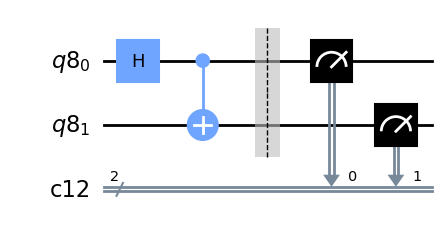

In [40]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)

qc.h(0)
qc.cx(0,1)
qc.barrier()
qc.measure(qr, cr)

qc.draw('mpl')

위 회로에 대하여 fake backend를 이용한 시뮬레이션을 실행하여 분포$\Pr(m)$를 구해보겠습니다.

In [41]:
num_shots = 4096

fake_rome = FakeRome()
job_fake_rome = fake_rome.run(qc, shots=4096)
result_fake_rome = job_fake_rome.result()
counts_fake_rome = result_fake_rome.get_counts()

print(counts_fake_rome)
pr_m = np.zeros(4, dtype=float)
for b, v in counts_fake_rome.items():
    pr_m[int(b, base=2)] = v/num_shots
print(pr_m)

{'00': 1889, '11': 1940, '01': 119, '10': 148}
[0.46118164 0.02905273 0.03613281 0.47363281]


read out error $\Pr(m|p)$를 측정하기 위해 다음과 같이 모든 computational basis에 대해 상태를 준비하여 실험을 수행합니다.

In [42]:
pr_m_p = np.zeros((4,4), dtype=float)

qr_mit = QuantumRegister(2)
cr_mit = ClassicalRegister(2)

# state prep = 00
qc_00 = QuantumCircuit(qr_mit, cr_mit)
qc_00.barrier()
qc_00.measure(qr_mit, cr_mit)
counts_00 = fake_rome.run(qc_00, shots=num_shots)\
    .result().get_counts()

pr_m_p[0][0] = counts_00['00']/num_shots if '00' in counts_00 else 0.0
pr_m_p[1][0] = counts_00['01']/num_shots if '01' in counts_00 else 0.0
pr_m_p[2][0] = counts_00['10']/num_shots if '10' in counts_00 else 0.0
pr_m_p[3][0] = counts_00['11']/num_shots if '11' in counts_00 else 0.0


# state prep = 01
qc_01 = QuantumCircuit(qr_mit, cr_mit)

qc_01.x(0)

qc_01.barrier()
qc_01.measure(qr_mit, cr_mit)
counts_01 = fake_rome.run(qc_01, shots=num_shots)\
    .result().get_counts()

pr_m_p[0][1] = counts_01['00']/num_shots if '00' in counts_01 else 0.0
pr_m_p[1][1] = counts_01['01']/num_shots if '01' in counts_01 else 0.0
pr_m_p[2][1] = counts_01['10']/num_shots if '10' in counts_01 else 0.0
pr_m_p[3][1] = counts_01['11']/num_shots if '11' in counts_01 else 0.0


# state prep = 10
qc_10 = QuantumCircuit(qr_mit, cr_mit)

qc_10.x(1)

qc_10.barrier()
qc_10.measure(qr_mit, cr_mit)
counts_10 = fake_rome.run(qc_10, shots=num_shots)\
    .result().get_counts()

pr_m_p[0][2] = counts_10['00']/num_shots if '00' in counts_10 else 0.0
pr_m_p[1][2] = counts_10['01']/num_shots if '01' in counts_10 else 0.0
pr_m_p[2][2] = counts_10['10']/num_shots if '10' in counts_10 else 0.0
pr_m_p[3][2] = counts_10['11']/num_shots if '11' in counts_10 else 0.0


# state prep = 11
qc_11 = QuantumCircuit(qr_mit, cr_mit)

qc_11.x(0)
qc_11.x(1)

qc_11.barrier()
qc_11.measure(qr_mit, cr_mit)
counts_11 = fake_rome.run(qc_11, shots=num_shots)\
    .result().get_counts()

pr_m_p[0][3] = counts_11['00']/num_shots if '00' in counts_11 else 0.0
pr_m_p[1][3] = counts_11['01']/num_shots if '01' in counts_11 else 0.0
pr_m_p[2][3] = counts_11['10']/num_shots if '10' in counts_11 else 0.0
pr_m_p[3][3] = counts_11['11']/num_shots if '11' in counts_11 else 0.0

np.set_printoptions(suppress=True)
print(pr_m_p)

[[0.95996094 0.03808594 0.03833008 0.0012207 ]
 [0.01977539 0.93725586 0.00024414 0.03100586]
 [0.02001953 0.0012207  0.93554688 0.03198242]
 [0.00024414 0.0234375  0.02587891 0.93579102]]


앞서 구한 실험 분포에 조건부확률 행렬의 역행렬을 곱하여 readout error가 보정된 결과를 얻을 수 있습니다.

In [43]:
pr_p = np.matmul(np.linalg.inv(pr_m_p), pr_m)
print("Before mitigation: ", pr_m)
print("After  mitigation: ", pr_p)

Before mitigation:  [0.46118164 0.02905273 0.03613281 0.47363281]
After  mitigation:  [0.4791668  0.00415884 0.01107895 0.50559541]


결과를 비교하기 위해 noiseless backend에서 시뮬레이션을 실행합니다.

In [44]:
qasm_backend = AerProvider().get_backend("qasm_simulator")
counts_qasm = qasm_backend.run(qc, shots=num_shots).result().get_counts()

pr_ideal = np.zeros(4, dtype=float)
for b, v in counts_qasm.items():
    pr_ideal[int(b, base=2)] = v/num_shots
print("Ideal probs: ", pr_ideal)

# convert pr_p to dict form
counts_mit = dict()
for i, v in enumerate(pr_p):
    counts_mit[bin(i)[2:].rjust(2, '0')] = v * num_shots

print("Fidelity without mitigation: ", hellinger_fidelity(counts_fake_rome, counts_qasm))
print("Fidelity with mitigation: ", hellinger_fidelity(counts_mit, counts_qasm))

Ideal probs:  [0.49975586 0.         0.         0.50024414]
Fidelity without mitigation:  0.9347759748597199
Fidelity with mitigation:  0.9845912520029243


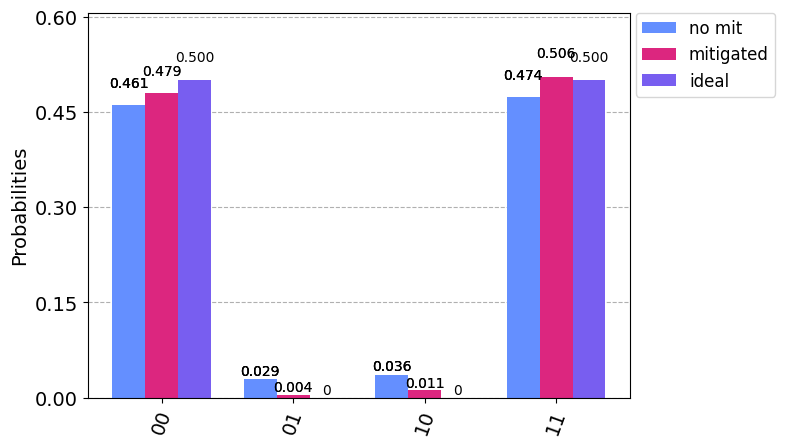

In [45]:
from qiskit.visualization import plot_histogram
plot_histogram([counts_fake_rome, counts_mit, counts_qasm],
               legend=['no mit', 'mitigated', 'ideal'])

### 3. Readout Error Mitigation (With tools)
qiskit에서 제공하는 readout mitigation tool을 이용하여 위의 과정을 다음과 같이 쉽게 구현할 수도 있습니다.

In [46]:
from qiskit.ignis.mitigation import CompleteMeasFitter, complete_meas_cal

meas_calibs, state_labels = complete_meas_cal(qr=qr_mit, circlabel='mcal')
for ckt in meas_calibs:
    print(ckt)

        ░ ┌─┐   
 q9_0: ─░─┤M├───
        ░ └╥┘┌─┐
 q9_1: ─░──╫─┤M├
        ░  ║ └╥┘
c14: 2/════╩══╩═
           0  1 
       ┌───┐ ░ ┌─┐   
 q9_0: ┤ X ├─░─┤M├───
       └───┘ ░ └╥┘┌─┐
 q9_1: ──────░──╫─┤M├
             ░  ║ └╥┘
c14: 2/═════════╩══╩═
                0  1 
             ░ ┌─┐   
 q9_0: ──────░─┤M├───
       ┌───┐ ░ └╥┘┌─┐
 q9_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
c14: 2/═════════╩══╩═
                0  1 
       ┌───┐ ░ ┌─┐   
 q9_0: ┤ X ├─░─┤M├───
       ├───┤ ░ └╥┘┌─┐
 q9_1: ┤ X ├─░──╫─┤M├
       └───┘ ░  ║ └╥┘
c14: 2/═════════╩══╩═
                0  1 


[[0.95336914 0.03833008 0.03051758 0.00195312]
 [0.02148438 0.93652344 0.00048828 0.0378418 ]
 [0.02490234 0.00097656 0.94677734 0.0402832 ]
 [0.00024414 0.02416992 0.0222168  0.91992188]]


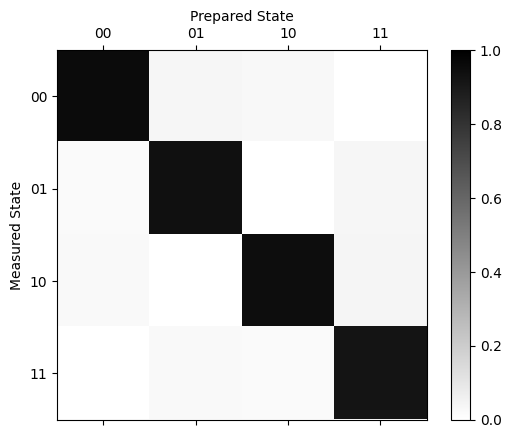

In [47]:
job_calibs = fake_rome.run(meas_calibs, shots=num_shots)
meas_fitter = CompleteMeasFitter(job_calibs.result(), state_labels, circlabel='mcal')

print(meas_fitter.cal_matrix)
meas_fitter.plot_calibration()

In [48]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_fake_rome)
mitigated_counts = mitigated_results.get_counts(0)

print("Fidelity with mitigation: ", hellinger_fidelity(mitigated_counts, counts_qasm))

Fidelity with mitigation:  0.9964055019466439
